# Quarterly Gains Report #1
- Princess Diana's Gains Guide

In [17]:
#basic imports
import numpy as np
import pandas as pd

#visualization libraries
import cufflinks as cf
cf.go_offline()

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.io as pio
from plotly.offline import iplot

import plotly.io as pio

from sqlalchemy import create_engine
engine = create_engine('sqlite:///../../gains.db')

In [2]:
def apply_golden_range(f: go.FigureWidget):
    '''
    If a line chart's axis doesn't start at 0, make 33% of the
    plot's y-axis space blank space. If the new minimum y-axis value
    becomes negative to fit the golden ratio and the old minimum y-axis
    value wasn't, then set y-axis minimum to 0. 
    
    This logic supports a design
    decision where if the chart's minimum is great than 0, the function
    assumes it does not make sense to use y values less than 0. For example, 
    in the case of lifting weights, one can lift little enough volume to 
    make setting a "golden range" require negative y-axis labelling, but
    entertaining negative numbers doesn't make sense since one cannot lift
    negative weight. In that case, setting the y-axis to 0 makes the best 
    use of space to ameliorate concerns with truncating y-axis ranges.
    
    Math:
    
    For a "golden range", the distance between the minimum data point 
    and the minimum y-axis value is one third the height of the entire
    plotting area, which is distance between the maximum y-axis value 
    and the minimum y-axis value:
    
    (min_data - min_y_range) = (max_y_range - min_y_range) / 3
    
    *transform equation*
    
    min_y_range =  (3 * min_data - max_y_range) / 2
    
    See discussion of fair y-axis ranges here: https://www.chezvoila.com/blog/yaxis
    
    This function relies on plotly automatically choosing the maximum y-axis value
    of a figure and simply changes the minimum y-axis value to make it conform
    to the golden ratio.
    '''
    
    if f.layout.yaxis.range[0] != 0:
        # get minimum y-axis data point of all the traces in the figure
        min_data = min([min(trace.y) for trace in f.data])
        
        # get current minimum and maxiumum y-axis range
        max_y_range = f.layout.yaxis.range[1]
        original_y_min = f.layout.yaxis.range[0]
        
        # get minimum y-axis range value to conform to golden ratio
        min_y_range = (3 * min_data - max_y_range) / 2
        
        # If the new minimum y-axis value is negative and the old minimum y-axis
        # value wasn't, then set y-axis minimum to 0
        if min_y_range < 0 and original_y_min > 0:
            min_y_range = 0
        
        # set new y-axis range
        f.layout.yaxis.range = [min_y_range, max_y_range]
    
    return f

def gains(df, color, category = 'abs'):
    '''
    Plot workout volume within a routine over time.
    '''
    # make the traces the column names in reverse, placing the total volume column in front for the largest subplot
    traces = df.columns
    
    # create subplots, one plot for each exercise in the routine
    if category == 'abs':
        subplots = tls.make_subplots(rows=3, cols=4, 
                              specs=[[{'colspan': 2, 'rowspan': 3}, None, {}, {}], # reserve one large subplot for the total volume field
                                     [None, None, {}, {}], # reserve remaining subplots for other exercises
                                     [None, None, {}, {}],
                                    ],
                                 subplot_titles = traces,
                              print_grid=True)
        # set row and col position list for plotting
        rows = [1,1,1,2,2,3,3]
        cols = [1,3,4,3,4,3,4,]
        x_axes = range(2,6)
        
    else:
        subplots = tls.make_subplots(rows=5, cols=4, 
                              specs=[[{'colspan': 2, 'rowspan': 5}, None, {}, {}], # reserve one large subplot for the total volume field
                                     [None, None, {}, {}], # reserve remaining subplots for other exercises
                                     [None, None, {}, {}],
                                     [None, None, {}, {}],
                                     [None, None, {}, {}]
                                    ],
                                 subplot_titles = traces,
                              print_grid=True)
        
        # set row and col position list for plotting
        rows = [1,1,1,2,2,3,3,4,4,5,5]
        cols = [1,3,4,3,4,3,4,3,4,3,4]
        x_axes = range(2,10)
    
    # intanstiate plot using the subplots
    f = go.FigureWidget(subplots)
    
    # create rolling 5-workout mean for each exercise
    means = df.rolling(5).mean()
    
    # plot each exercise in its own subplot
    for row, col, trace in zip(rows, cols, traces):
        
        # print values for diagnostic purposes
        print(trace)
        print(row, col)
        
        # plot exercise volumes then rolling means
        for frame in [df, means]:

            # exercise volumes
            f.add_scatter(x = frame.index, y = frame[trace], 
                          mode = 'lines',
                          opacity = 1 if frame is means else .45,
                          marker = {'color':f'{color}'} if frame is means else {'color': 'grey'},
                          line = {'shape': 'spline', 'width': 3.5} if frame is means else {}, # make the rolling means smooth but the normal value normal
                          showlegend = False, 
                          name = trace if frame is df else 'Mean',
                          row = row, col= col)
    
    # hide x-axis values for the upper-most plots, leaving on the x-axis of the bottom plots for better visibility
    for axis in x_axes:
        f.layout[f'xaxis{axis}'].visible = False
        #f.layout[f'yaxis{axis}'].range = df.min().min(), df.max().max()
    
    # add my signature logo
    f.layout.images = [dict(
        source="https://raw.githubusercontent.com/WilliamGreenlaw/Logos/master/signature_min.png",
        xref="paper", yref="paper",
        x= .1, y= 1,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
      )]
    
    # set axis labels
    f.layout.yaxis.title = 'Volume (lbs)'
    
    # set colors
    f.layout.plot_bgcolor = '#E5E5E5'
    f.layout.paper_bgcolor = '#E5E5E5'    
    
    return f

def sort_volume(df):
    return df.sort_values(by = df.index[-1], axis = 1, ascending = False)

In [44]:
volume = pd.read_sql('volume', con = engine, parse_dates = 'date')

In [4]:
workouts  = pd.read_csv('../../fitnotes/workouts.csv')

In [46]:
categories = [['Chest', 'Triceps'], ['Back'], ['Abs']]
chest, back, ab = [volume
                   .loc[(volume.routine == 'Princess Diana Gains Guide') & 
                                 volume.category.isin(category)]
                   .pivot(index = 'date', columns = 'exercise', values = 'volume')
                   .fillna(0)
                   .assign(total_volume = lambda df: df.sum(axis = 1))
                   .rename(columns = {'total_volume': 'Total Volume'})
                   .pipe(sort_volume)
                   for category in categories]

In [6]:
figs = {}

In [47]:
figs['abs'] = gains(ab, color = '#037F8C', category = 'abs')
figs['abs'].layout.title = '<b>Ab Volume Rises Because of Weighted Exercises</b><br><i>Ab Volume over Time, Five-Workout Average in Black'

This is the format of your plot grid:
[ (1,1) x1,y1           -      ]  [ (1,3) x2,y2 ]  [ (1,4) x3,y3 ]
       |             (empty)      [ (2,3) x4,y4 ]  [ (2,4) x5,y5 ]
       |                |         [ (3,3) x6,y6 ]  [ (3,4) x7,y7 ]

Total Volume
1 1
Decline Oblique Chops
1 3
Mounted Oblique Leans
1 4
Ab-Wheel Rollout Side-Side-Front
2 3
Med Ball Spread Eagles
2 4
Hanging Front Snap Kick Raise
3 3
Hanging Knee Raise
3 4


In [48]:
figs['chest'] = gains(chest, color = '#A6431F', category = 'chest')
figs['chest'].layout.title = '<b>Chest Volume Has Declined Since February 1st, 2018</b><br><i>Chest Volume over Time, Five-Workout Average in Black'

This is the format of your plot grid:
[ (1,1) x1,y1             -        ]  [ (1,3) x2,y2 ]    [ (1,4) x3,y3 ]  
       |               (empty)        [ (2,3) x4,y4 ]    [ (2,4) x5,y5 ]  
       |               (empty)        [ (3,3) x6,y6 ]    [ (3,4) x7,y7 ]  
       |               (empty)        [ (4,3) x8,y8 ]    [ (4,4) x9,y9 ]  
       |                  |           [ (5,3) x10,y10 ]  [ (5,4) x11,y11 ]

Total Volume
1 1
Decline Barbell Bench Press
1 3
Close Grip Dip
1 4
Decline Cable Fly
2 3
Decline Dumbbell Fly
2 4
Lower Chest Bracket Pushups
3 3
Decline Dumbbell Bench Press
3 4
Flat Barbell Bench Press
4 3
Incline Barbell Bench Press
4 4
Incline Pushup
5 3
Single Arm Hammer Strength Press
5 4


In [50]:
figs['back'] = gains(back, color = '#5B4973', category = 'back')
figs['back'].layout.title = '<b>Back Volume Has Stagnated on Average over Time</b><br><i>Back Volume over Time, Five-Workout Average in Black'

This is the format of your plot grid:
[ (1,1) x1,y1             -        ]  [ (1,3) x2,y2 ]    [ (1,4) x3,y3 ]  
       |               (empty)        [ (2,3) x4,y4 ]    [ (2,4) x5,y5 ]  
       |               (empty)        [ (3,3) x6,y6 ]    [ (3,4) x7,y7 ]  
       |               (empty)        [ (4,3) x8,y8 ]    [ (4,4) x9,y9 ]  
       |                  |           [ (5,3) x10,y10 ]  [ (5,4) x11,y11 ]

Total Volume
1 1
Pull Up
1 3
Wide Lat Pulldown Supinated
1 4
Bent Over EZ Bar Cable Rows
2 3
Barbell Row
2 4
Single Arm Cable Pulldown
3 3
Bent Over Single Arm Cable Rows with Twist
3 4
Bent Over Rope Pulldowns
4 3
Reverse Cable Fly
4 4
Seated Back Extension
5 3
Inverted Rows
5 4


In [52]:
figs['chest']

FigureWidget({
    'data': [{'marker': {'color': 'grey'},
              'mode': 'lines',
              'name':…

In [53]:
figs['chest'].layout.xaxis.showgrid = False
figs['chest'] = apply_golden_range(figs['chest'])

In [54]:
figs['back']

FigureWidget({
    'data': [{'marker': {'color': 'grey'},
              'mode': 'lines',
              'name':…

In [55]:
figs['back'].layout.xaxis.showgrid = False
figs['back'] = apply_golden_range(figs['back'])

In [56]:
figs['abs']

FigureWidget({
    'data': [{'marker': {'color': 'grey'},
              'mode': 'lines',
              'name':…

In [57]:
figs['abs'].layout.xaxis.showgrid = False

In [58]:
pio.write_image(figs['back'], 'back.svg', width = 1500, height = 500)
pio.write_image(figs['chest'], 'chest.svg', width = 1500, height = 500)
pio.write_image(figs['abs'], 'abs.svg', width = 1500, height = 500)

In [59]:
pio.write_image(figs['back'], 'back.png', width = 1500, height = 600)
pio.write_image(figs['chest'], 'chest.png', width = 1500, height = 600)
pio.write_image(figs['abs'], 'abs.png', width = 1500, height = 600)

In [20]:
diana = workouts.loc[workouts.routine == 'Princess Diana Gains Guide']

In [21]:
since = diana.pivot(index = 'date', columns = 'category', values = 'days_since_category')

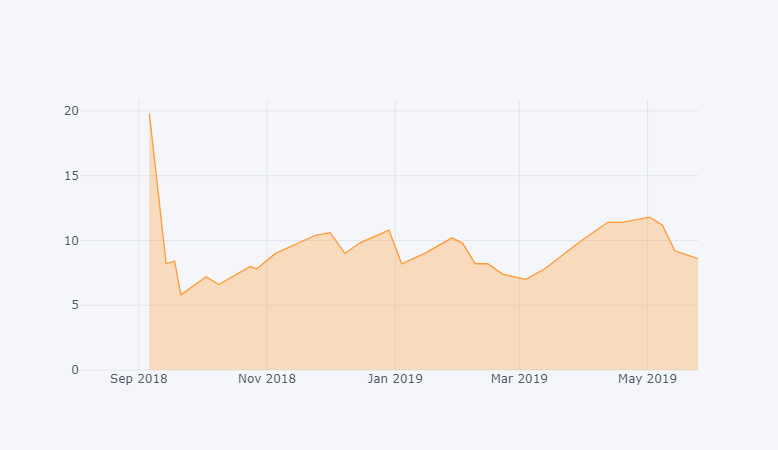

In [27]:
since.Abs.dropna().rolling(5).mean().iplot(fill = True)

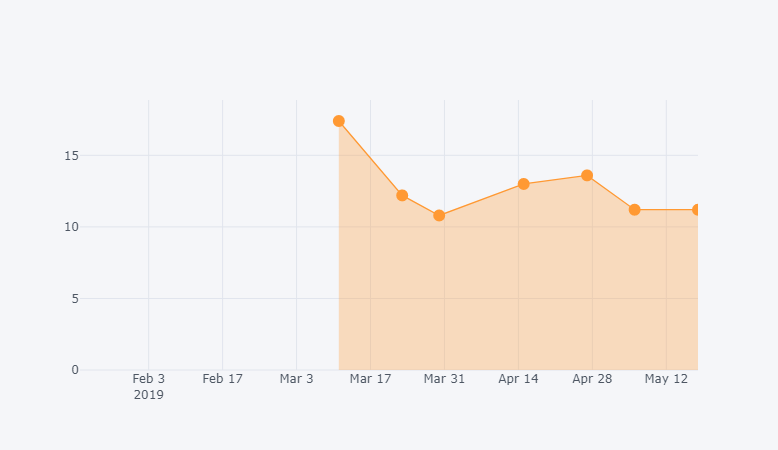

In [23]:
since.Back.dropna().rolling(5).mean().iplot(fill = True, mode = 'lines+markers')

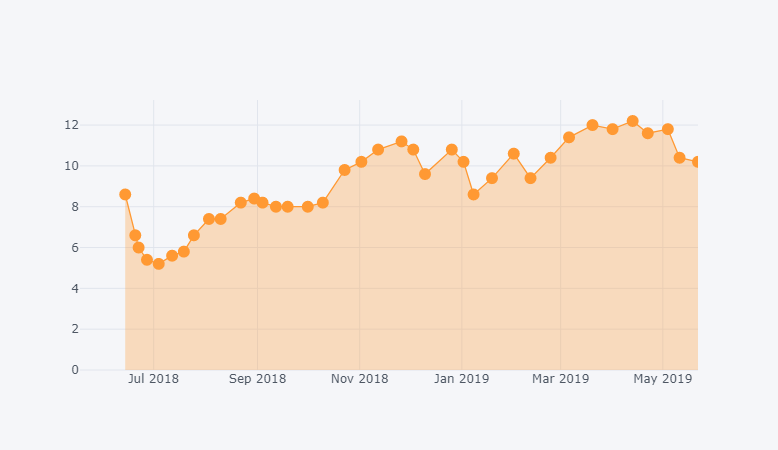

In [24]:
since.Chest.dropna().rolling(5).mean().iplot(fill = True, mode = 'lines+markers')